<a href="https://colab.research.google.com/github/MikeCilliers/AWS-SageMaker-Fundamentals-R-Workshop/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quick demo: Vision Transformer (ViT) by Google Brain

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. Note that there have been made some improvements already (such as [DeiT](https://ai.facebook.com/blog/data-efficient-image-transformers-a-promising-new-technique-for-image-classification/) by Facebook AI = Data Efficient Image Transformers), which I also ported to HuggingFace Transformers.

Each image is split into a sequence of non-overlapping patches (of resolutions like 16x16 or 32x32), which are linearly embedded. This is also known as a convolution operation according to some ;) next, absolute position embeddings are added, and sent through a stack of encoder layers. A [CLS] token is added at the beginning in order to get a representation of the entire image. A linear classification head can be added on top of the final hidden state in order to classify images.

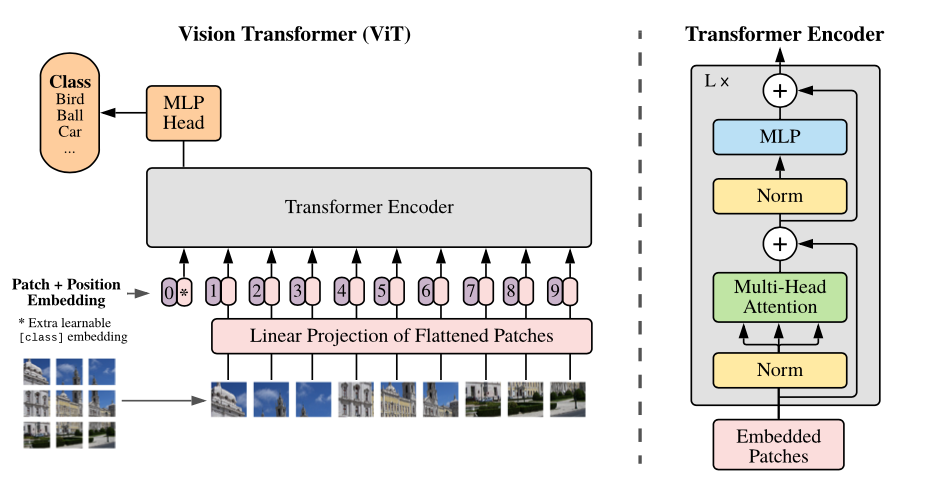

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

I've converted the timm model (Ross Weightman, the author of timm, has already ported the weights from JAX to his PyTorch implementation so there's no need to reinvent the wheel). The timm implementation can be found [here](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py).

This notebook is inference-only. If you're interested in fine-tuning ViT on your own dataset, consider my notebooks in my [Transformers-Tutorials repo](https://github.com/NielsRogge/Transformers-Tutorials), where I fine-tune ViT on CIFAR-10 using the 🤗 Trainer/PyTorch Lightning.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 


Let's load the model from the hub, and move it to GPU.

In [2]:
from transformers import ViTForImageClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()
model.to(device)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

Let's load in an image and let it perform predictions.

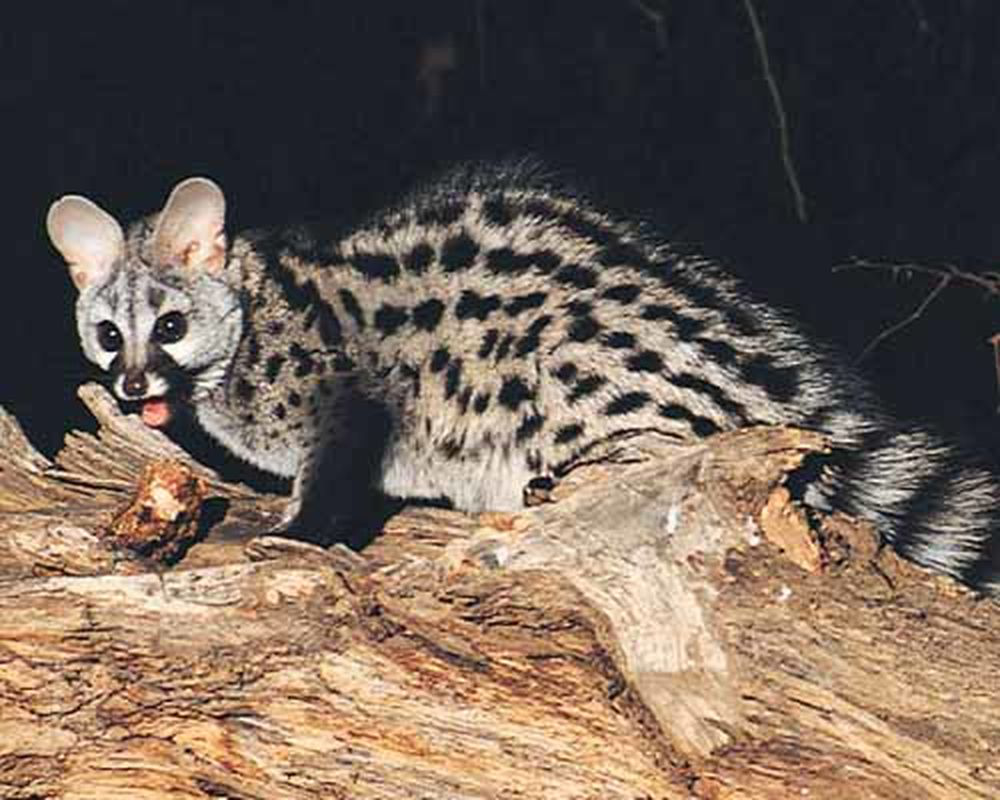

In [15]:
from PIL import Image
import requests

url = 'https://africageographic.com/wp-content/uploads/2021/07/DSC01611.jpg'
url = 'https://capeleopard.org.za/images/open_graph/home.jpg'
url = 'https://namibian.org/img/cms/nature/animals/galleries/smallspottedgenetfs_max1200x800.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im

Let's first apply the regular image preprocessing. This model accepts an input resolution of 224x224. We use `ViTFeatureExtractor`, which takes care of resizing + normalization.

In [16]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
encoding = feature_extractor(images=im, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values'])

In [17]:
encoding['pixel_values'].shape

torch.Size([1, 3, 224, 224])

## Forward pass

Let's send the image through the ViT model, which consists of a BERT-like encoder and a linear classification head on top of the last hidden state of the [CLS] token.



In [18]:
pixel_values = encoding['pixel_values'].to(device)

outputs = model(pixel_values)
logits = outputs.logits
logits.shape

torch.Size([1, 1000])

In [19]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: great grey owl, great gray owl, Strix nebulosa
